In [1]:
%matplotlib inline


# Gromov-Wasserstein Barycenter example


This example is designed to show how to use the Gromov-Wasserstein distance
computation in POT.



In [2]:
# Author: Erwan Vautier <erwan.vautier@gmail.com>
#         Nicolas Courty <ncourty@irisa.fr>
#
# License: MIT License


import numpy as np
import scipy as sp

import scipy.ndimage as spi
import matplotlib.pylab as pl
from sklearn import manifold
from sklearn.decomposition import PCA

import ot

Smacof MDS
----------

This function allows to find an embedding of points given a dissimilarity matrix
that will be given by the output of the algorithm



In [3]:
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensionned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

    rng = np.random.RandomState(seed=3)

    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=rng,
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos

Data preparation
----------------

The four distributions are constructed from 4 simple images



In [4]:
def im2mat(I):
    """Converts and image to matrix (one pixel per line)"""
    return I.reshape((I.shape[0] * I.shape[1], I.shape[2]))


square = spi.imread('../data/square.png').astype(np.float64)[:, :, 2] / 256
cross = spi.imread('../data/cross.png').astype(np.float64)[:, :, 2] / 256
triangle = spi.imread('../data/triangle.png').astype(np.float64)[:, :, 2] / 256
star = spi.imread('../data/star.png').astype(np.float64)[:, :, 2] / 256

shapes = [square, cross, triangle, star]

S = 4
xs = [[] for i in range(S)]


for nb in range(4):
    for i in range(8):
        for j in range(8):
            if shapes[nb][i, j] < 0.95:
                xs[nb].append([j, 8 - i])

xs = np.array([np.array(xs[0]), np.array(xs[1]),
               np.array(xs[2]), np.array(xs[3])])

/home/rflamary/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/home/rflamary/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
/home/rflamary/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/home/rflamary/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


Barycenter computation
----------------------



In [5]:
ns = [len(xs[s]) for s in range(S)]
n_samples = 30

"""Compute all distances matrices for the four shapes"""
Cs = [sp.spatial.distance.cdist(xs[s], xs[s]) for s in range(S)]
Cs = [cs / cs.max() for cs in Cs]

ps = [ot.unif(ns[s]) for s in range(S)]
p = ot.unif(n_samples)


lambdast = [[float(i) / 3, float(3 - i) / 3] for i in [1, 2]]

Ct01 = [0 for i in range(2)]
for i in range(2):
    Ct01[i] = ot.gromov.gromov_barycenters(n_samples, [Cs[0], Cs[1]],
                                           [ps[0], ps[1]
                                            ], p, lambdast[i], 'square_loss',  # 5e-4,
                                           max_iter=100, tol=1e-3)

Ct02 = [0 for i in range(2)]
for i in range(2):
    Ct02[i] = ot.gromov.gromov_barycenters(n_samples, [Cs[0], Cs[2]],
                                           [ps[0], ps[2]
                                            ], p, lambdast[i], 'square_loss',  # 5e-4,
                                           max_iter=100, tol=1e-3)

Ct13 = [0 for i in range(2)]
for i in range(2):
    Ct13[i] = ot.gromov.gromov_barycenters(n_samples, [Cs[1], Cs[3]],
                                           [ps[1], ps[3]
                                            ], p, lambdast[i], 'square_loss',  # 5e-4,
                                           max_iter=100, tol=1e-3)

Ct23 = [0 for i in range(2)]
for i in range(2):
    Ct23[i] = ot.gromov.gromov_barycenters(n_samples, [Cs[2], Cs[3]],
                                           [ps[2], ps[3]
                                            ], p, lambdast[i], 'square_loss',  # 5e-4,
                                           max_iter=100, tol=1e-3)

Visualization
-------------

The PCA helps in getting consistency between the rotations



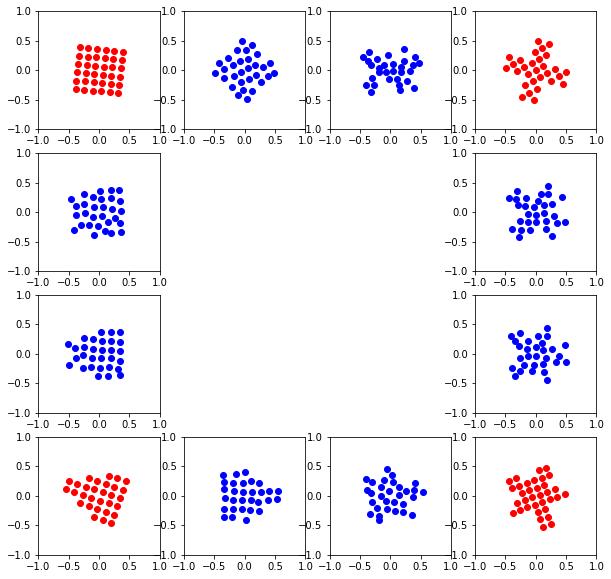

In [6]:
clf = PCA(n_components=2)
npos = [0, 0, 0, 0]
npos = [smacof_mds(Cs[s], 2) for s in range(S)]

npost01 = [0, 0]
npost01 = [smacof_mds(Ct01[s], 2) for s in range(2)]
npost01 = [clf.fit_transform(npost01[s]) for s in range(2)]

npost02 = [0, 0]
npost02 = [smacof_mds(Ct02[s], 2) for s in range(2)]
npost02 = [clf.fit_transform(npost02[s]) for s in range(2)]

npost13 = [0, 0]
npost13 = [smacof_mds(Ct13[s], 2) for s in range(2)]
npost13 = [clf.fit_transform(npost13[s]) for s in range(2)]

npost23 = [0, 0]
npost23 = [smacof_mds(Ct23[s], 2) for s in range(2)]
npost23 = [clf.fit_transform(npost23[s]) for s in range(2)]


fig = pl.figure(figsize=(10, 10))

ax1 = pl.subplot2grid((4, 4), (0, 0))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax1.scatter(npos[0][:, 0], npos[0][:, 1], color='r')

ax2 = pl.subplot2grid((4, 4), (0, 1))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax2.scatter(npost01[1][:, 0], npost01[1][:, 1], color='b')

ax3 = pl.subplot2grid((4, 4), (0, 2))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax3.scatter(npost01[0][:, 0], npost01[0][:, 1], color='b')

ax4 = pl.subplot2grid((4, 4), (0, 3))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax4.scatter(npos[1][:, 0], npos[1][:, 1], color='r')

ax5 = pl.subplot2grid((4, 4), (1, 0))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax5.scatter(npost02[1][:, 0], npost02[1][:, 1], color='b')

ax6 = pl.subplot2grid((4, 4), (1, 3))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax6.scatter(npost13[1][:, 0], npost13[1][:, 1], color='b')

ax7 = pl.subplot2grid((4, 4), (2, 0))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax7.scatter(npost02[0][:, 0], npost02[0][:, 1], color='b')

ax8 = pl.subplot2grid((4, 4), (2, 3))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax8.scatter(npost13[0][:, 0], npost13[0][:, 1], color='b')

ax9 = pl.subplot2grid((4, 4), (3, 0))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax9.scatter(npos[2][:, 0], npos[2][:, 1], color='r')

ax10 = pl.subplot2grid((4, 4), (3, 1))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax10.scatter(npost23[1][:, 0], npost23[1][:, 1], color='b')

ax11 = pl.subplot2grid((4, 4), (3, 2))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax11.scatter(npost23[0][:, 0], npost23[0][:, 1], color='b')

ax12 = pl.subplot2grid((4, 4), (3, 3))
pl.xlim((-1, 1))
pl.ylim((-1, 1))
ax12.scatter(npos[3][:, 0], npos[3][:, 1], color='r')